# Project 7: Modeling an RF Communication System with Autoencoder in PyTorch

## 1. Objective

The aim of this project is to introduce the idea of the Autoencoder, showing an application in the telecommunications area.

In this application, an Autoencoder network will be implemented to encode symbols sent over a channel with *Additive White Gaussian Noise (AWGN)*, generating its own constellation.

In the end, the results obtained using the Autoencoder will be compared with the performance of the optimal detector, in order to equalize the error rate of the two systems.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import math
from scipy.special import erfc
from pylab import *
from sklearn.manifold import TSNE
import utils

%matplotlib inline

Before we start implementing the actual code, let's check if there are any GPUs available to run the codes, with the aim of speeding up the training of the DNN.

In [15]:
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    device = torch.device("cuda")
    print("Training on GPU.")
else:
    device = torch.device("cpu")
    print("GPU unavailable, training on CPU.")

Training on GPU.


## 3. Theoretical Introduction

### 3.1 *Communication System*

A Communication System is made up of modules that act to format the signal that will be transmitted and how the received signal will be interpreted. In the figure below we see a diagram of the modules that make up the communication system: in the transmitter, we have the *encoding* and *modulation* processes; while in the receiver there are the *demodulation* and *decoding* blocks.

The *channel* (or communication channel, or even communication medium) represents the physical path by which the message leaves the transmitter and reaches the receiver, thus forming a communication link, be it a wire (twisted pair or copper), optical fiber or even the air itself. Based on the established communication channel, the engineer in charge designs the communication system to meet the communication requirements and the adversities imposed by the physical conditions of the channel (such as attenuation and interference).

For wireless communication systems, the physical medium is air, so the transmitted signal is subject to changes coming from the channel, such as interference (from other signals on the same frequency), multiple paths, noise, attenuation and even the Doppler effect (if it's a mobile device).

To do this, there are *encoding* and *modulation* blocks in the transmitter which aim to find the best representation of the **transmitted signal**, while in the receiver there are *demodulation* and *decoding* blocks so that what coding and modulation (plus the channel) have done to the **original signal** can be undone.

Knowing the adversities imposed by the communication channel, **modulation** techniques aim to find the best representation for the signal, so that the signal can be transmitted through the channel to the receiver, i.e. find a format so that the signal can be transmitted through the channel to the receiver and, when received, can be demodulated and decoded effectively.

Coding, on the other hand, focuses on finding the best code to represent the message signal, a code that can determine whether or not a message has been corrupted and, in some cases, even find the error and correct it.

Therefore, with coding and modulation, the original message signal is altered so that it can be transmitted and withstand the adversities imposed by the channel. In such a way that the **demodulation** and **decoding** blocks will undo what was done in the previous blocks so that communication can be completed.

If we think of the communication system as a single block, a black box, we can say that the transmitter sends the message $M$ and what comes out of the receiver is a reconstruction of the original message that passed through the system $\widehat{M}$, as we can see in the figure below.

The M-QAM modulation technique maps message signals onto points in a two-dimensional vector space (state diagram), where each point is made up of a tuple representing the signals in phase and amplitude.

The image below shows the constellation for 4-QAM. Thus, point (-1,-1) represents message {00}, point (-1,1) represents message {01}, point (1,1) represents message {11} and point (1,-1) represents message {10}. In the digital world, we work with bits (binary representations), so for each point we have 2 bits, i.e. each tuple represents a set of 2 bits, and with two bits you can have 4 different message signs, so we have $M=2^{k}$ message signs, with $k$ being the number of bits.

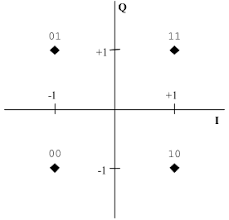

As a further example, here is an image of the 16-QAM Constellation, so $M=16$ and $k=4$. Here are some relevant points about the $M$ modulation order:

* The higher the $M$, the higher the modulation order;
* Each point in space represents $k$ bits;
* The transmission rate, bits per second [bps], increases according to $k$, as long as the time to transmit a message remains unchanged with the variation in this parameter;
* The greater the $M$, the shorter the distance between the points, assuming the average symbol energy remains unchanged, thus increasing the signal's vulnerability to noise and interference.

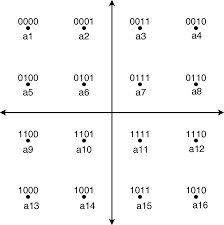

Knowing the communication channel is extremely important so that, through modulation and coding, we can adapt the message signal in such a way that the communication process can be completed efficiently.
Communication systems are generally designed to achieve the lowest possible error rate. Therefore, the fewer errors, the better the communication and the more effective it will be. Thus, a widely used indicator to characterize communication systems is the bit error rate curve, or *Block  Error Rate* (BLER) curves, which represents the error rate of blocks of transmitted bits.
These curves are presented in a Mono-Log graph, where the Y-axis shows the error rate for a given signal-to-noise ratio, in Decibels [dB], expressed on the X-axis.
In this notebook, SNR is conventionally given in the expression $E_{b}/N_{0}$, i.e. we'll use these terms analogously. In simplified form, for digital communications systems, we consider the average bit energy $E_{b}$ and the noise power $N_{0}$, as measures of the ratio between the transmitted signal energy and the system noise energy, the SNR.

The image below shows the theoretical BER curves for some communication systems with M-QAM modulation. The first is that the higher the signal-to-noise ratio, the lower the error rates, i.e. the higher the energy of the transmitted symbol and the lower the energy of the noise, the fewer errors there are in the system. The second point is that the higher the modulation order $M$, the higher the $E_{b}/N_{0}$ requirements, i.e. for a fixed error rate (take $10^{-2}$, for example), the higher the signal-to-noise ratio values as $M$ increases.

Taking into account requirements such as power, the channel's signal-to-noise ratio, the transmission rate in [bps] and the required error rate, the best M-QAM modulation scheme can be determined for the communication system in question.

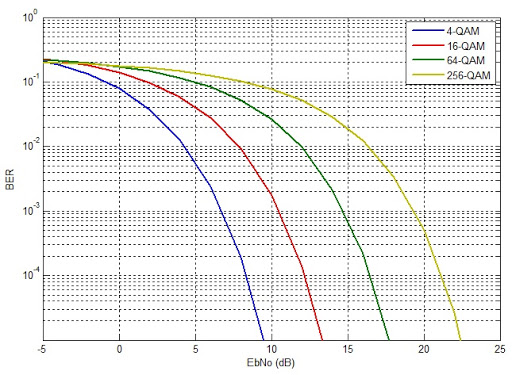

### 3.2 *The Autoencoder* (AE)
The Autoencoder is a *machine learning* technique that uses neural networks to assemble a single system made up of a neural network that performs the encoding (the encoder) and another neural network for the decoding (the decoder) of a given input.

The focus of the Autoencoder is on the representation of the input data by the encoder and the decoder's ability to reconstruct the input data from the generated representation. An example of how Autoencoder can be used is to reduce the dimensionality of images, or even to explore and determine features (certain characteristics and/or information) of images.

In the figure below, we see an example of using the autoencoder. The input is an image representing the number two. As it passes through the encoder, it generates a new representation of the image. This compressed representation is then placed at the input of the decoder so that it can reconstruct the original image.

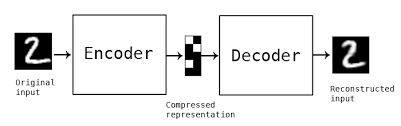

According to (Ian Goodfellow, 2016), the Autoencoder is a neural network that is trained to try to copy the inputs into the output, and internally has a hidden layer called $h$ that encodes the input data into a new representation.

The neural network is made up of two parts, the encoder which encodes the input data defined as $h = f(x)$ and the decoder which reconstructs the original data from the established representation, defined as $r = g(h)$, thus obtaining the architecture shown in the figure below.

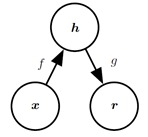

Thus, for the autoencoder to be successful, it only needs to learn $g(f(x)) = x$ for any trained input value $x$. This neural network model prioritizes the main characteristics of the input in the new representation.

The coding space generated by the encoder is called the *latent space*. If $M$ is the number of elements in the encoder input and $n$ is the number of elements in the encoder output, there are two situations for autoencoders:

* If $M > n$: we have a **subcomplete** autoencoder, i.e. the number of elements in the representation space, the latent space, is less than the number of elements in the input.
* If $M < n$: we have an **overcomplete** autoencoder, i.e. the number of elements in the representation space, the latent space, is greater than the number of elements in the input.

In the image below we can see an architecture for the autoencoder.

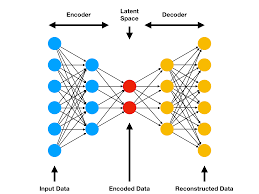

# Autoencoder applied to the RF system

To overcome the channel's intrinsic adversities, the modules that make up the communication system can be analyzed and improved individually. In this process, the processes of coding and modulating the signals (messages/symbols) stand out, since together they aim to find the best representation of the symbols to be transmitted on the communication channel.

In addition to conventional techniques based on statistical models of the channel, techniques based on machine learning are gaining more and more ground in the field of telecommunications, and one application that is currently being studied is the use of such machine learning techniques to determine the best representation of transmission symbols.

We can therefore assign the Autoencoder the responsibility of finding the best representation of the message signals for a given channel model!

### 4.1 Considerations

Here we will make some considerations about the problem and how to adapt a communication system to the autoencoder structure presented.

**1)** The number of **channel uses**, defined as $n$. Each message has a certain time interval in which it has the channel resources available for it to be transmitted, and this will be done in the form of $n$ symbols in series in time (channel uses).

**2)** The channel model used in this experiment will be AWGN, so the received signal will be modeled as follows: $y = x + r$, where $y$ is the received signal, $x$ the symbol transmitted in each use of the channel and $r$ the noise which will be a Gaussian random variable with mean zero and variance $\sigma^2$.

**3)** The variance used to model AWGN noise. Knowing that $\sigma^2 = N_{0}/2$ and defining $R = k/n$ as the bit rate per use of the channel, we arrive at the closed solution for the standard deviation of the noise:
$$\sigma = \sqrt{\frac{1}{2* R * \tfrac{E_{b}}{N_{0}}}}$$

**4)** For the notation and architecture of the autoencoder, we will use the notation $AE(n,k)$, where $n$ is the number of uses of the channel for transmission and $k$, the number of bits of the message signal. Note that for this system we have $M=2^k$ possible messages, and each message will be transmitted in the form of $n$ symbols.
**For each message $s \in M$, we will encode the message $s$ in a one-hot vector. The one-hot vector representation establishes that only one position (it can be the column or the row) is equal to 1 and the rest equal to 0, i.e. we can map a message signal '0110' into the one-hot vector '0100'.

The neural network architecture used in this experiment is shown in the image below. First we will map the $M$ messages (which is of the form $M$x$1$) into a matrix $M$x$M$, where each row represents a message and the columns are the representation in one-hot vector format.

For a one-hot vector as input, we will pass it through a neural network and then through a normalization layer, so that $x$ is obtained. Then we add the noise with zero mean and variance $\sigma^2$ already defined, generating the signal $y$, and this signal added to the noise will pass through another layer of neural network, in which in the last layer we will have an activation function $softmax$.

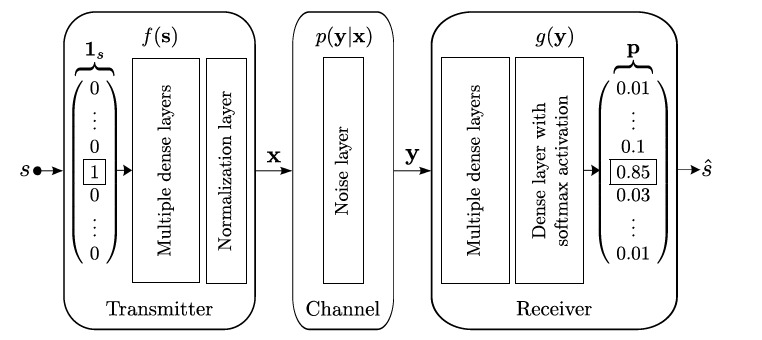

### 4.2 Creating the Model
The Autoencoder class is structured as follows.

It can be seen that two pieces of information are required to create this class:

- The first is the number of messages $M$.
- The second is the size of the latent space defined by the variable **n_net**.
Within the *forward* function we highlight a few processes:
- The first is the Euclidean normalization applied. This normalization refers to the power/energy restrictions on the signal.
- The second is the creation of noise using the *torch.normal* function, which requires the bit rate/usage of the channel $R$ and the signal-to-noise ratio $E_{b}/N_{0}$.

The *auto_encoder* and *auto_decoder* functions were created for future reference, since the *forward* function is dedicated to training the neural network.

In [16]:
class autoencoder(nn.Module):
    def __init__(self, M, n_net):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(M, n_net),
            nn.ReLU(True),
            nn.Linear(n_net, n_net),
            nn.BatchNorm1d(n_net, affine=True),
        )

        self.decoder = nn.Sequential(
            nn.Linear(n_net, M), nn.ReLU(True), nn.Linear(M, M), nn.Softmax(dim=1)
        )

    def forward(self, x, R, n_net, EbN0):
        outs = {}
        x_size = x.shape[0]
        x = self.encoder(x)
        x = nn.functional.normalize(x, p=2, dim=-1)
        x = x * (math.sqrt(n_net / 2))
        outs["encoded"] = x
        noise_channel = torch.normal(
            0.0, math.sqrt(1 / (2 * R * (10.0 ** (EbN0 / 10.0)))), [x_size, n_net]
        )
        x = x + noise_channel
        outs["encoded_noise"] = x
        x = self.decoder(x)
        outs["decoded"] = x
        return outs

    def auto_encoder(self, x, n_channel):
        x = self.encoder(x)
        x = nn.functional.normalize(x, p=2, dim=-1)
        x = x * (n_channel / math.sqrt(n_channel))
        return x

    def auto_decoder(self, x):
        x = self.decoder(x)
        return x

#### 4.2.1 Autoencoder parameters

First let's define the parameters for building the network. We will train the AE(2,2) autoencoder model, where $n=2$ and $k=2$, so we have $M=4$ and a bit rate per channel use equal to 1 ($R=1$).

As $M=4$ we can map the messages as follows:
* Message 0 (00) -> 0001 in the form of a one-hot vector;
* Message 1 (01) -> 0010 in the form of a one-hot vector;
* Message 2 (10) -> 0100 in one-hot vector form;
* Message 3 (11) -> 1000 in the form of a one-hot vector;

Note that $n=2$ means that we will use the channel twice (two symbols) to transmit a single message. For a given message, the encoder will generate the following representation: $encoder(M_i) => (x^{(i)}_{In_{1}}, x^{(i)}_{Qn_{1}}),(x^{(i)}_{In_{2}}, x^{(i)}_{Qn_{2}})$, i.e. for $i$ = 1, 2, ... , $M$, we'll enter the one-hot vector of the message $M_i$ and the encoder will generate a vector of the form 2*$n$x1 (remember that we're working with complex symbols that have the signal in phase and in quadrature), so we'll have a vector of the form 4x1 at the encoder's output, where, in the first use of the channel, we will send the two components of the first symbol, $(x^{(i)}_{In_{1}}, x^{(i)}_{Qn_{1}})$, and, in the second use of the channel, we will send the two components of the second symbol $(x^{(i)}_{In_{2}}, x^{(i)}_{Qn_{2}})$.

In [17]:
k = 2
n_channel = 2
M = 2**k
R = k / n_channel
EbN0 = 7
n_simbolos = 2
n_net = n_simbolos * n_channel

#### 4.2.2 Model creation

Here we create the model based on the configured data.

In [18]:
model = autoencoder(M, n_net)

### 4.3 Autoenoder training

#### 4.3.1 Autoencoder Training Parameters

In [19]:
learning_rate = 3e-3
num_epochs = 2000
batch_size = 10 * M
N_treino = batch_size * 10

The training or test dataset for our problem can be created in the same way as the previous parameters.

As we need a one-hot vector representation of the message signals, we used the *torch.eye()* function to generate an identity matrix, $I_M$, for the $M$ possible messages.

However, we want a training dataset the size of **N_training** (a parameter defined previously). So we use the *torch.repeat()* function, which will repeat the $I_M$ identity matrix generated **N_training**/$M$ times. So in the end we have a dataset with **N_training** samples in one-hot vector format.

In [20]:
train_dataset = torch.eye(M)
data = train_dataset.repeat(int(N_treino / M), 1)

#### 4.3.2 Training Routine

For training, we will use the Cross-Entropy function to calculate the error obtained between the decoder reconstruction and the transmitted signal. We will use the Adam algorithm to update the weights of the neural networks.

Note that we're using the *DataLoader* function to format our dataset, we've passed the generated data as parameters, the batch size we'll use and we've enabled the *shuffle* function that will shuffle this data.

Also note that we have created a variable to store the error for each epoch so that at the end we can plot the Loss x Epoch graph.

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
loss_epoch = []
for epoch in range(num_epochs):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
    for input_in in dataloader:
        output = model(input_in, R, n_net, EbN0)
        target_crossEntropy = torch.argmax(input_in, dim=-1).type(torch.LongTensor)
        loss = criterion(output["decoded"], target_crossEntropy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_epoch.append(loss.data)
    print("epoch [{}/{}], loss:{:.4f}".format(epoch + 1, num_epochs, loss.data))

epoch [1/2000], loss:1.3739
epoch [2/2000], loss:1.3396
epoch [3/2000], loss:1.3488
epoch [4/2000], loss:1.2954
epoch [5/2000], loss:1.3658
epoch [6/2000], loss:1.2649
epoch [7/2000], loss:1.2137
epoch [8/2000], loss:1.2159
epoch [9/2000], loss:1.2445
epoch [10/2000], loss:1.2278
epoch [11/2000], loss:1.1467
epoch [12/2000], loss:1.0618
epoch [13/2000], loss:1.2519
epoch [14/2000], loss:1.1057
epoch [15/2000], loss:1.1330
epoch [16/2000], loss:1.1060
epoch [17/2000], loss:1.0895
epoch [18/2000], loss:1.1134
epoch [19/2000], loss:1.0294
epoch [20/2000], loss:1.0369
epoch [21/2000], loss:1.1119
epoch [22/2000], loss:1.0712
epoch [23/2000], loss:1.0924
epoch [24/2000], loss:1.1016
epoch [25/2000], loss:1.0137
epoch [26/2000], loss:1.0322
epoch [27/2000], loss:1.0850
epoch [28/2000], loss:1.0414
epoch [29/2000], loss:0.9996
epoch [30/2000], loss:1.0603
epoch [31/2000], loss:1.0441
epoch [32/2000], loss:1.1379
epoch [33/2000], loss:1.0610
epoch [34/2000], loss:1.0395
epoch [35/2000], loss:0

### 4.4 Testing the Autoencoder

In addition to the training phase, there are the validation and test phases. In general, the validation phase is used to determine the accuracy of the model and to analyze the network parameters, but we will go straight to the test phase so that we can evaluate some other aspects of the autoencoder's operation.

#### 4.4.1 Autoencoder test parameters

Just as we did for the training, we will repeat the process of generating the dataset for the test. First we define the number of test samples, **N_test**, then we use the *torch.randint* function to generate random values from 0 to M-1, so we can use these values as *labels* later. Finally, we transform the values of the labels into one-hot vectors.

Note that we have trained our autoencoder for a specific value of $E_b/N_0$, now we want to test this same autoencoder for several different signal-to-noise ratios, and for this we will create a vector to store the BER values.

In [22]:
N_teste = 100000 * M
test_label = torch.randint(0, M, (N_teste,))
test_data = torch.nn.functional.one_hot(test_label).float()
EbNodB_range = torch.arange(0, 8, 0.5)
ber = [None] * len(EbNodB_range)

#### 4.4.2 Test Routine

In this phase we will only test the trained autoencoder model for different values of $E_b/N_0$, so we will have different values of $\sigma^2$, generating different dispersions of the noise values, i.e. we will test the autoencoder for different types of AWGN channels.

In general, we will first shuffle the test data, then separate it again into labels and test data. Now we'll use the previously defined *auto_encoder* and *auto_decoder* functions to encode, add the generated noise and decode. After decoding, we transform the output vector into a list and use the *np.argmax()* function, which returns the value of the position with the largest value in the input list.

Finally, we compare the output results with the initial labels, using the comparison to find the different values, i.e. those that don't match, transforming the vector in Boolean format ('True' or 'False') into a vector of 0's and 1's and adding the values equal to 1 to determine the bit error rate.

In [23]:
for n in range(0, len(EbNodB_range)):
    EbNo = 10.0 ** (EbNodB_range[n] / 10.0)
    noise_std = np.sqrt(1 / (2 * R * EbNo)).item()
    noise_mean = 0.0
    no_errors = 0
    noise = torch.normal(noise_mean, noise_std, [N_teste, n_net])
    data = TensorDataset(test_data, torch.LongTensor(test_label))
    dataloader_test = DataLoader(data, batch_size=N_teste, shuffle=True)
    test_data_ = dataloader_test.dataset.tensors[0]
    label_ = np.array(dataloader_test.dataset.tensors[1])
    encoded_signal = model.auto_encoder(test_data_, n_net / 2)
    channel_signal = encoded_signal + noise
    pred_final_signal = model.auto_decoder(channel_signal)
    parse_pred_output = pred_final_signal.tolist()
    pred_output = np.argmax(parse_pred_output, axis=1)
    no_errors = pred_output != label_
    no_errors = no_errors.astype(int).sum()
    ber[n] = no_errors / N_teste
    print("SNR:", EbNodB_range[n].item(), "BLER:", ber[n], "no_errors:", no_errors)

/tmp/ipykernel_55266/3782369172.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  noise_std = np.sqrt(1 / (2 * R * EbNo)).item()


SNR: 0.0 BLER: 0.1291075 no_errors: 51643
SNR: 0.5 BLER: 0.1075925 no_errors: 43037
SNR: 1.0 BLER: 0.088675 no_errors: 35470
SNR: 1.5 BLER: 0.0714725 no_errors: 28589
SNR: 2.0 BLER: 0.05589 no_errors: 22356
SNR: 2.5 BLER: 0.04246 no_errors: 16984
SNR: 3.0 BLER: 0.0312175 no_errors: 12487
SNR: 3.5 BLER: 0.02222 no_errors: 8888
SNR: 4.0 BLER: 0.01538 no_errors: 6152
SNR: 4.5 BLER: 0.0101025 no_errors: 4041
SNR: 5.0 BLER: 0.006575 no_errors: 2630
SNR: 5.5 BLER: 0.00383 no_errors: 1532
SNR: 6.0 BLER: 0.0022075 no_errors: 883
SNR: 6.5 BLER: 0.001075 no_errors: 430
SNR: 7.0 BLER: 0.00053 no_errors: 212
SNR: 7.5 BLER: 0.000235 no_errors: 94


### 4.5 Results Plots

#### 4.5.1 Loss plot

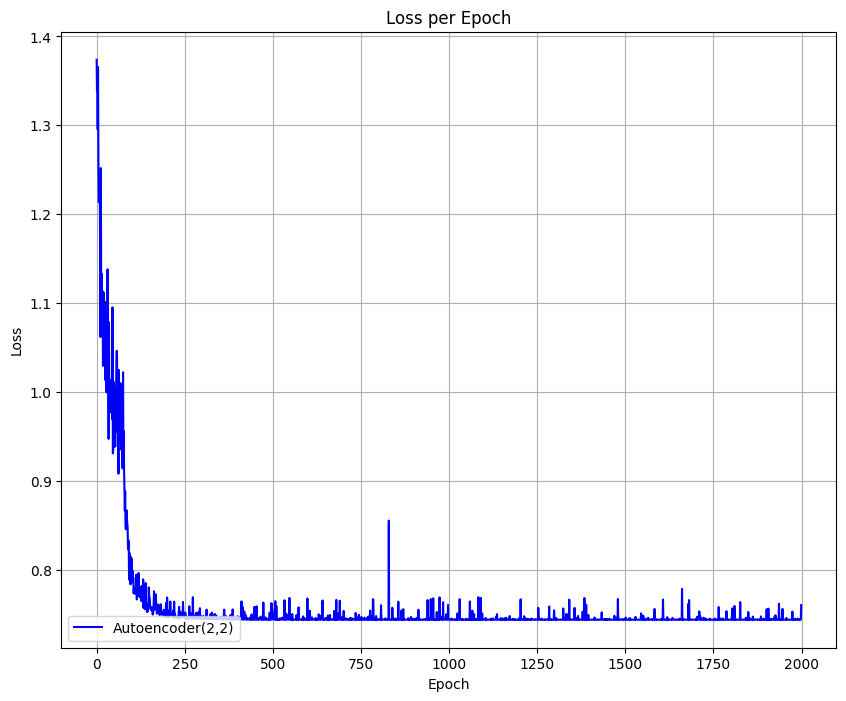

In [24]:
vector_loss = np.arange(0, len(loss_epoch), 1)
fig = plt.figure(figsize=(10, 8))
plt.plot(vector_loss, loss_epoch, "b", label="Autoencoder(%d,%d)" % (n_channel, k))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend(loc="lower left", ncol=1)
plt.grid()
plt.show()

#### 4.5.2 BLER graph

Our mission is to achieve a better BLER result with Autoencoder than with conventional techniques.

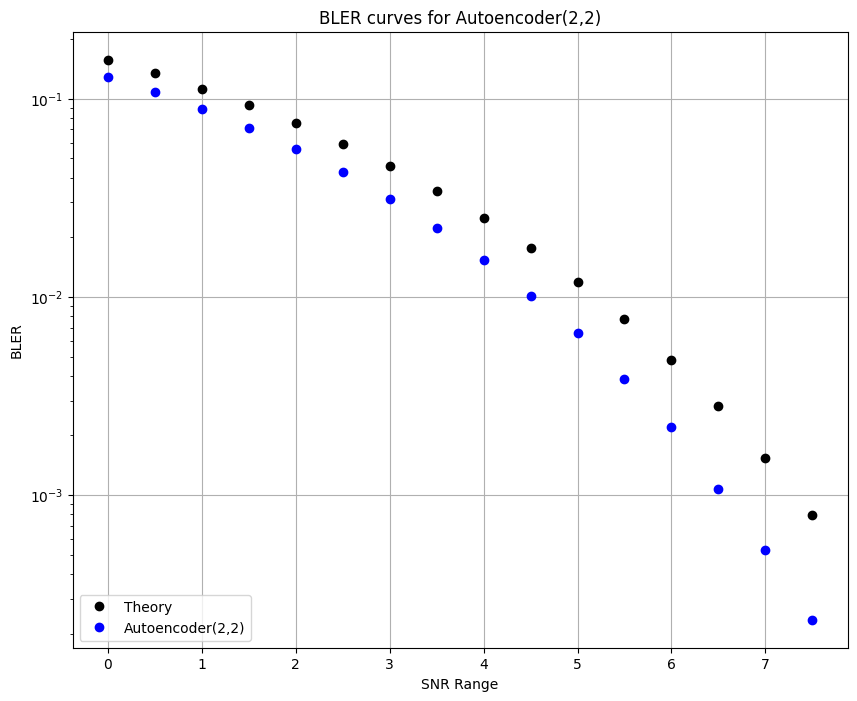

In [25]:
ask_M, psk_M, qam_M = utils.genareteBER(2**k, EbNodB_range)

fig = plt.figure(figsize=(10, 8))
fig_title = "BLER curves for Autoencoder(" + str(n_channel) + "," + str(k) + ")"
plt.plot(EbNodB_range, qam_M, "ko", label="Theory")
plt.plot(EbNodB_range, ber, "bo", label="Autoencoder(%d,%d)" % (n_channel, k))
plt.yscale("log")
plt.xlabel("SNR Range")
plt.ylabel("BLER")
plt.title(fig_title)
plt.grid()
plt.legend(loc="lower left", ncol=1)
plt.show()

#### 4.5.3 Gráfico da Constelação

<Figure size 640x480 with 0 Axes>

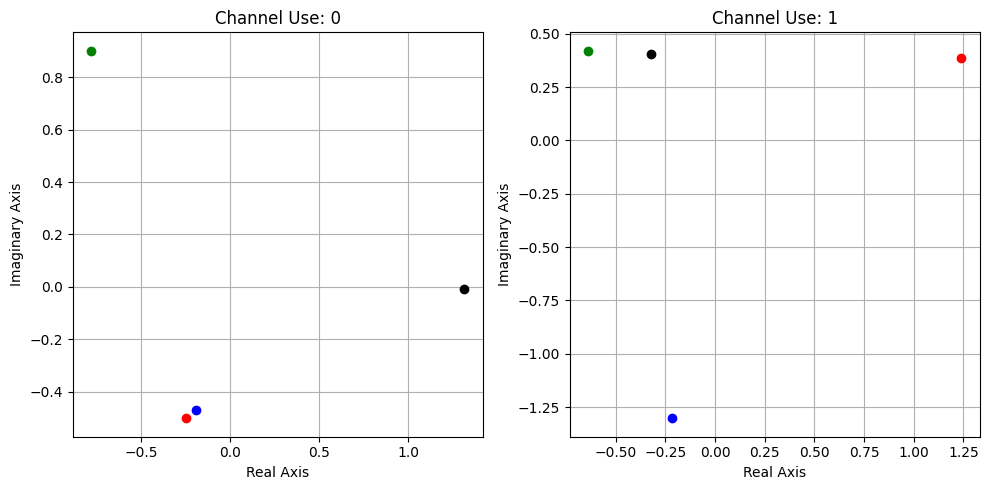

In [26]:
data_encoded_symbol = model.auto_encoder(torch.eye(M), n_channel)
real_symb, imag_symb = utils.split_symb(data_encoded_symbol)
utils.plot_graphs(
    real_symb.detach().numpy(), imag_symb.detach().numpy(), n_channel, sizefig=5
)